In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

import veritas
import xgboost as xgb
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load MNIST from OpenML

In [3]:
X, y_mc = datasets.fetch_openml(data_id=554, return_X_y=True, as_frame=False, parser='auto')
X = X.astype(veritas.FloatT)

In [4]:
y = y_mc.astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=6)
num_classes = 10

# Train an XGBoost model

In [5]:
# NOTE performances here are pretty bad, we used small trees to show practicalities of the new methods/structures
params = {
    "n_estimators": 5,
    "num_class": num_classes,
    "objective": "multi:softmax",
    "eval_metric": "merror",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 3,#7,
    "learning_rate": 0.2,
    "colsample_bynode": 0.75,
    "subsample": 0.5
}
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

XGB trained in 3.634887218475342 seconds


In [6]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

Train acc: 0.833, test acc: 0.833 wrt true labels


# Convert multiclass XGB to a multiclass AddTree

In [7]:
at = veritas.get_addtree(model)

XGB converter: manually determined base_score [0.5        0.5        0.50000001 0.50000009 0.50000005 0.50000001
 0.49999996 0.50000009 0.49999995 0.50000001]  (dump value 0.500000)


In [8]:
print(at[0])

Node(id=0, split=[F358 < 65], sz=15, left=1, right=2)
├─ Node(id=1, split=[F407 < 1], sz=7, left=3, right=4)
│  ├─ Node(id=3, split=[F512 < 64], sz=3, left=5, right=6)
│  │  ├─ Leaf(id=5, sz=1, value=[-0.0443172, 0, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=6, sz=1, value=[0.342307, 0, 0, 0, 0, 0, 0, 0, 0, 0])
│  ├─ Node(id=4, split=[F332 < 250], sz=3, left=7, right=8)
│  │  ├─ Leaf(id=7, sz=1, value=[-0.108874, 0, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=8, sz=1, value=[0.160305, 0, 0, 0, 0, 0, 0, 0, 0, 0])
├─ Node(id=2, split=[F462 < 1], sz=7, left=9, right=10)
│  ├─ Node(id=9, split=[F567 < 1], sz=3, left=11, right=12)
│  │  ├─ Leaf(id=11, sz=1, value=[0.282737, 0, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=12, sz=1, value=[0.922592, 0, 0, 0, 0, 0, 0, 0, 0, 0])
│  ├─ Node(id=10, split=[F509 < 235], sz=3, left=13, right=14)
│  │  ├─ Leaf(id=13, sz=1, value=[-0.0791489, 0, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=14, sz=1, value=[0.215956, 0, 0, 0, 0, 0, 0, 0, 0, 0])



In [9]:
print(at[6])

Node(id=0, split=[F437 < 1], sz=15, left=1, right=2)
├─ Node(id=1, split=[F550 < 1], sz=7, left=3, right=4)
│  ├─ Node(id=3, split=[F346 < 1], sz=3, left=5, right=6)
│  │  ├─ Leaf(id=5, sz=1, value=[0, 0.386617, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=6, sz=1, value=[0, -0.0907352, 0, 0, 0, 0, 0, 0, 0, 0])
│  ├─ Node(id=4, split=[F435 < 236], sz=3, left=7, right=8)
│  │  ├─ Leaf(id=7, sz=1, value=[0, -0.106681, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=8, sz=1, value=[0, -0.00861321, 0, 0, 0, 0, 0, 0, 0, 0])
├─ Node(id=2, split=[F323 < 245], sz=7, left=9, right=10)
│  ├─ Node(id=9, split=[F437 < 37], sz=3, left=11, right=12)
│  │  ├─ Leaf(id=11, sz=1, value=[0, -0.0840774, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=12, sz=1, value=[0, -0.107534, 0, 0, 0, 0, 0, 0, 0, 0])
│  ├─ Node(id=10, split=[F466 < 1], sz=3, left=13, right=14)
│  │  ├─ Leaf(id=13, sz=1, value=[0, 0.181212, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=14, sz=1, value=[0, -0.102898, 0, 0, 0, 0, 0, 0, 0, 0])



In [10]:
# By default, Veritas optimizes the 0th class. One can swap classes into the first position in order to optimize other classes
at.swap_class(1)
# the method simply swaps the order of the classes in the leaf value vectors: now in position 0 we have values related to class 1
# check first tree as example:
print(at[0])

Node(id=0, split=[F358 < 65], sz=15, left=1, right=2)
├─ Node(id=1, split=[F407 < 1], sz=7, left=3, right=4)
│  ├─ Node(id=3, split=[F512 < 64], sz=3, left=5, right=6)
│  │  ├─ Leaf(id=5, sz=1, value=[0, -0.0443172, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=6, sz=1, value=[0, 0.342307, 0, 0, 0, 0, 0, 0, 0, 0])
│  ├─ Node(id=4, split=[F332 < 250], sz=3, left=7, right=8)
│  │  ├─ Leaf(id=7, sz=1, value=[0, -0.108874, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=8, sz=1, value=[0, 0.160305, 0, 0, 0, 0, 0, 0, 0, 0])
├─ Node(id=2, split=[F462 < 1], sz=7, left=9, right=10)
│  ├─ Node(id=9, split=[F567 < 1], sz=3, left=11, right=12)
│  │  ├─ Leaf(id=11, sz=1, value=[0, 0.282737, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=12, sz=1, value=[0, 0.922592, 0, 0, 0, 0, 0, 0, 0, 0])
│  ├─ Node(id=10, split=[F509 < 235], sz=3, left=13, right=14)
│  │  ├─ Leaf(id=13, sz=1, value=[0, -0.0791489, 0, 0, 0, 0, 0, 0, 0, 0])
│  │  └─ Leaf(id=14, sz=1, value=[0, 0.215956, 0, 0, 0, 0, 0, 0, 0, 0])



# Train a better model, extract one base example

In [11]:
# same as above, with deeper trees
params["max_depth"] = 7
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)
print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

XGB trained in 7.375861883163452 seconds
Train acc: 0.944, test acc: 0.945 wrt true labels


In [12]:
at = veritas.get_addtree(model)

XGB converter: manually determined base_score [0.50000002 0.49999999 0.50000001 0.50000001 0.5        0.50000002
 0.5        0.49999999 0.50000001 0.50000001]  (dump value 0.500000)


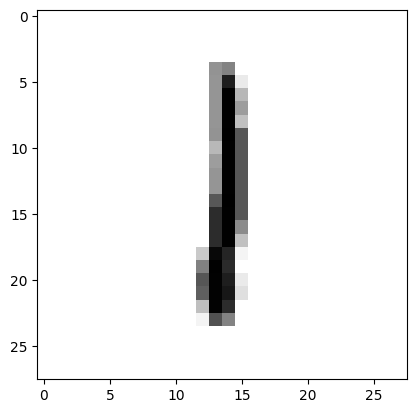

In [13]:
# select one example of class 1
number_of_adv_examples = 1

rng = np.random.default_rng(seed=6)
xtest0 = xtest[ytest_pred==1, :]
subset = xtest0[rng.choice(range(xtest0.shape[0]), number_of_adv_examples), :].astype(veritas.FloatT)

plt.imshow((subset[0, :]).reshape((28,28)), cmap="binary")

In [14]:
# test outputs for chosen base example
base_example = subset[0, :]
y_xgb = model.predict_proba(subset)
y_ats = at.predict(subset)
y_xgb, y_ats

(array([[0.04417546, 0.59047586, 0.04704807, 0.04537885, 0.04444005,
         0.04573073, 0.04549549, 0.04539688, 0.04544771, 0.04641085]],
       dtype=float32),
 array([[0.04417547, 0.59047583, 0.04704808, 0.04537886, 0.04444006,
         0.04573074, 0.0454955 , 0.04539689, 0.04544772, 0.04641086]]))

# MAX_MAX example: targeted attack - one adv. ex. per class

In [15]:
# idea: we start with a base example of class 1
# we try to generate an adversarial example classfied in each of the other classes (0, 2, 3, ..., 9)
# a soltuion for class 0 is the solution to the maximization problem: 
# max_x [ T_0(x) - max_c (T_c(x)) ]
# i.e., class0 is preferred over each other class

In [16]:
### MAX_MAX multiclass

adv_examples = []
atc = at.copy()
eps  = 10

# once per class (class0 --> class1, class0 --> class2, ...)
for c in range(0, num_classes):
    if c==1:
        continue
        
    print(c)
    atc.swap_class(c)

    config = veritas.Config(veritas.HeuristicType.MULTI_MAX_MAX_OUTPUT_DIFF)
    config.ignore_state_when_worse_than = 0.0
    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    s = config.get_search(atc, prune_box)
    s.set_max_memory(16*1024*1024*1024)

    tstart = time.time()
    while s.num_solutions() == 0:
        stop_reason = s.steps(1000)
        #print(s.stats.num_steps, stop_reason)
        if stop_reason != veritas.StopReason.NONE:
            break
        
    tstop = time.time()

    atc.swap_class(c) #go back to original addtree for evaluation

    if s.num_solutions() > 0:
        sol = s.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, 1e-5)

        res = {"c": c, "adv_example": adv_example, "base_example": base_example}

        print(at.eval(base_example)[0])
        print(at.eval(adv_example)[0])
        print(sol.output)
        print()
        print()

        adv_examples.append(res)
        
    else:
        print("no adversarial examples found for", c)

    #break

0
[-0.03833442  2.55442471  0.02466609 -0.01145763 -0.03236276 -0.00373325
 -0.00889066 -0.0110605  -0.00994132  0.01102955]
[ 0.11052552 -0.00879231 -0.00747202 -0.01308482 -0.00747558 -0.00932727
 -0.00708447 -0.01233514 -0.01096541 -0.01351509]
0.11760998763207349


2
[-0.03833442  2.55442471  0.02466609 -0.01145763 -0.03236276 -0.00373325
 -0.00889066 -0.0110605  -0.00994132  0.01102955]
[-3.83344169e-02  8.12967891e-02  2.77504839e+00  3.81985871e-02
 -3.23627645e-02  4.08028617e-02  9.97873736e-03  4.84941308e-03
 -1.49903818e-02 -2.22443214e-03]
2.693751606976157


3
[-0.03833442  2.55442471  0.02466609 -0.01145763 -0.03236276 -0.00373325
 -0.00889066 -0.0110605  -0.00994132  0.01102955]
[-0.03833442  0.08129679  0.07904958  1.32245938 -0.0355055  -0.01327924
  0.07037354 -0.01444804  0.01785042  0.01039507]
1.2411626001761575


4
[-0.03833442  2.55442471  0.02466609 -0.01145763 -0.03236276 -0.00373325
 -0.00889066 -0.0110605  -0.00994132  0.01102955]
[-0.03833442  0.00368459  0

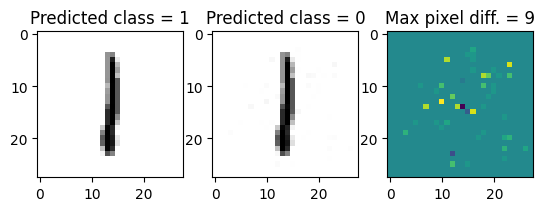

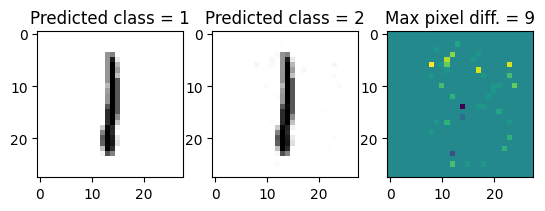

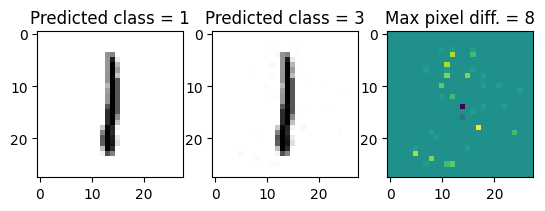

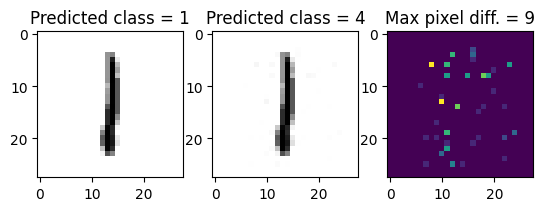

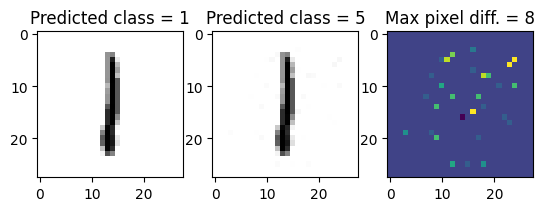

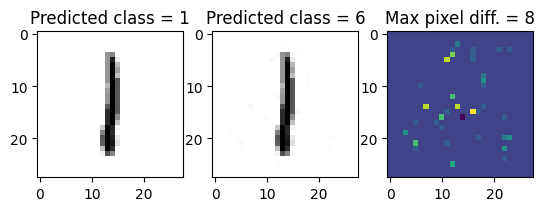

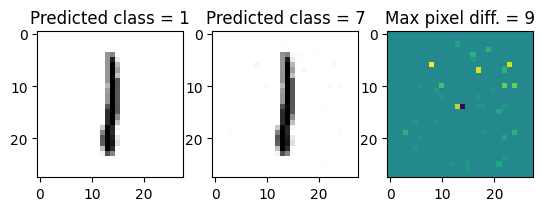

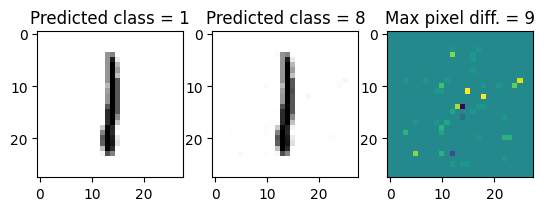

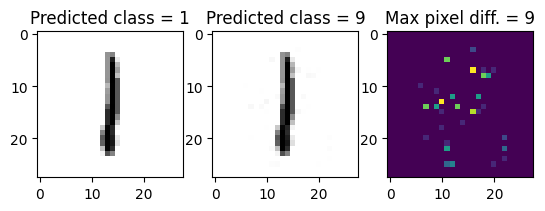

In [17]:
for i, res in enumerate(adv_examples):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow((res["base_example"]).reshape((28,28)), cmap="binary")
    base_class = np.argmax(at.eval(res["base_example"])[0])
    ax[0].set_title(f"Predicted class = {base_class}")
    adv_class = np.argmax(at.eval(res["adv_example"])[0])
    ax[1].imshow((res["adv_example"]).reshape((28,28)), cmap="binary")
    ax[1].set_title(f"Predicted class = {adv_class}")
    ax[2].imshow((res["adv_example"]-res["base_example"]).reshape((28,28)))
    max_diff = np.max(np.abs(res["base_example"]-res["adv_example"]))
    ax[2].set_title(f"Max pixel diff. = {int(max_diff)}")

In [18]:
# smaller eps so that we sometime fail
eps = 5
adv_examples = []
atc = at.copy()

# once per class (class0 --> class1, class0 --> class2, ...)
for c in range(0, num_classes):
    if c==1:
        continue
        
    #print(c)
    atc.swap_class(c)

    config = veritas.Config(veritas.HeuristicType.MULTI_MAX_MAX_OUTPUT_DIFF)
    config.ignore_state_when_worse_than = 0.0
    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    s = config.get_search(atc, prune_box)
    s.set_max_memory(16*1024*1024*1024)

    tstart = time.time()
    while s.num_solutions() == 0:
        stop_reason = s.steps(1000)
        if stop_reason != veritas.StopReason.NONE:
            break
        
    tstop = time.time()

    atc.swap_class(c)

    if s.num_solutions() > 0:
        sol = s.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, 1e-5)

        res = {"i": i, "adv_example": adv_example, "base_example": base_example}
        adv_examples.append(res)
        
    else:
        print("no adversarial examples found for class", c)

no adversarial examples found for class 4


In [19]:
# we did not find an adv. ex. for class 4
# what if we do simple binary classification 4vAll (trying to maximize for class 4)?

In [20]:
### MAX_OUTPUT binary classification setting

# only take trees for c vs 1
for c in range(0, num_classes):

    #if c==1:
    if c!=4:
        continue

    print("c", c)
    
    atc1 = at.contrast_classes(c, 1)

    config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
    config.ignore_state_when_worse_than = 0.0
    prune_box = [veritas.Interval(max(0.0, x-eps), min(255, x+eps)) for x in base_example]
    s = config.get_search(atc1, prune_box)
    s.set_max_memory(16*1024*1024*1024)
    
    while s.num_solutions() == 0:
        if s.steps(100) != veritas.StopReason.NONE:
            break
    
    if s.num_solutions() > 0:
        sol = s.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example, 1e-5)

        if c==4:
            print(atc1.eval(base_example)[0])
            print(atc1.eval(adv_example)[0], sol.output)
            print()
            print(at.eval(base_example)[0])
            print(at.eval(adv_example)[0], sol.output)
            print("  ==> predicted class:", np.argmax(at.eval(adv_example)[0]))
            print()
        
    else:
        print("no adversarial examples found")

c 4
[-2.58678747]
[0.00176948] 0.0017694795199750535

[-0.03833442  2.55442471  0.02466609 -0.01145763 -0.03236276 -0.00373325
 -0.00889066 -0.0110605  -0.00994132  0.01102955]
[-0.03833442 -0.03413224  0.02466609 -0.01145763 -0.03236276 -0.00373325
 -0.00889066 -0.0110605  -0.00994132  0.01102955] 0.0017694795199750535
  ==> predicted class: 2



In [21]:
# We find a result, BUT inspecting the evaluation on the full addTree we see that 
# such result would not be classified as Class 4 in a multiclass setting - it would be a 2! 
# The two problems are slightly different.